In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
def plot_concatenated_accuracy(fairness_report, sensitive_feature, classes):
    """
    Creates concatenated graphs for accuracy across all classes for a sensitive feature.

    Args:
        fairness_report (dict): Report containing accuracy by group for each sensitive feature and class.
        sensitive_feature (str): Sensitive feature (e.g., ENROLL_AGE_GROUPS, SEX).
        classes (list): List of class labels from COHORT.
    """
     
    # Initialize the data structure for plotting
    groups = list(fairness_report[(classes[0], sensitive_feature)]["Accuracy by Group"].keys())
    group_positions = range(len(groups))  # Positions for each group
    bar_width = 0.2  # Width of each bar

    # Define colors for each class
    colors = ["skyblue", "salmon", "lightgreen", "gold"]

    # Create a bar chart
    plt.figure(figsize=(14, 6))

    for i, class_label in enumerate(classes):
        if (class_label, sensitive_feature) in fairness_report:
            accuracy_by_group = fairness_report[(class_label, sensitive_feature)]["Accuracy by Group"]
            accuracies = [accuracy_by_group[group] for group in groups]
            
            # Offset each bar for overlap
            bar_positions = [p + (i * bar_width) - (bar_width * len(classes) / 2) for p in group_positions]
            plt.bar(bar_positions, accuracies, bar_width, label=f"Class {class_label}", color=colors[i])

    # Add titles, labels, and legend
    plt.title(f"Overlapping Group-wise Accuracy for {sensitive_feature}")
    plt.xlabel(f"{sensitive_feature}")
    plt.ylabel("Accuracy")
    plt.xticks(group_positions, groups, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3]:
# Load the dataset
data = pd.read_csv('airflow_cleaned_data_unscaled.csv')

# Define features and sensitive attributes
X = data.drop(columns=["COHORT", "ENROLL_AGE", "SEX"])  # Drop target and sensitive features
y = data["COHORT"]
sensitive_features = data[["ENROLL_AGE", "SEX"]]  # Sensitive features for fairness evaluation

# Bin the 'ENROLL_AGE' feature into ranges
sensitive_features["ENROLL_AGE_GROUPS"] = pd.cut(
    sensitive_features["ENROLL_AGE"],
    bins=[0, 20, 40, 60, 80, 100],  # Define bins (adjust as needed)
    labels=["0-20", "21-40", "41-60", "61-80", "81+"],
    right=False
)

C:\Users\yutik\AppData\Local\Temp\ipykernel_8588\3049358002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitive_features["ENROLL_AGE_GROUPS"] = pd.cut(


In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test, sensitive_features_train, sensitive_features_test = train_test_split(
    X, y, sensitive_features, test_size=0.2, random_state=42
)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


Fairness Evaluation for Class 4:

  Sensitive Feature: ENROLL_AGE_GROUPS
    Demographic Parity Difference: 0.34391534391534395
    Equalized Odds Difference: 0.3076923076923077
    Accuracy by Group for ENROLL_AGE_GROUPS:
ENROLL_AGE_GROUPS
21-40    0.733333
41-60    0.908571
61-80    0.925926
81+      0.944444
Name: accuracy_score, dtype: float64

  Sensitive Feature: SEX
    Demographic Parity Difference: 0.13013937282229965
    Equalized Odds Difference: 0.01640862776233956
    Accuracy by Group for SEX:
SEX
0.0    0.920732
1.0    0.916667
Name: accuracy_score, dtype: float64

Fairness Evaluation for Class 1:

  Sensitive Feature: ENROLL_AGE_GROUPS
    Demographic Parity Difference: 0.27777777777777773
    Equalized Odds Difference: 0.14285714285714285
    Accuracy by Group for ENROLL_AGE_GROUPS:
ENROLL_AGE_GROUPS
21-40    0.933333
41-60    0.948571
61-80    0.979630
81+      1.000000
Name: accuracy_score, dtype: float64

  Sensitive Feature: SEX
    Demographic Parity Difference: 

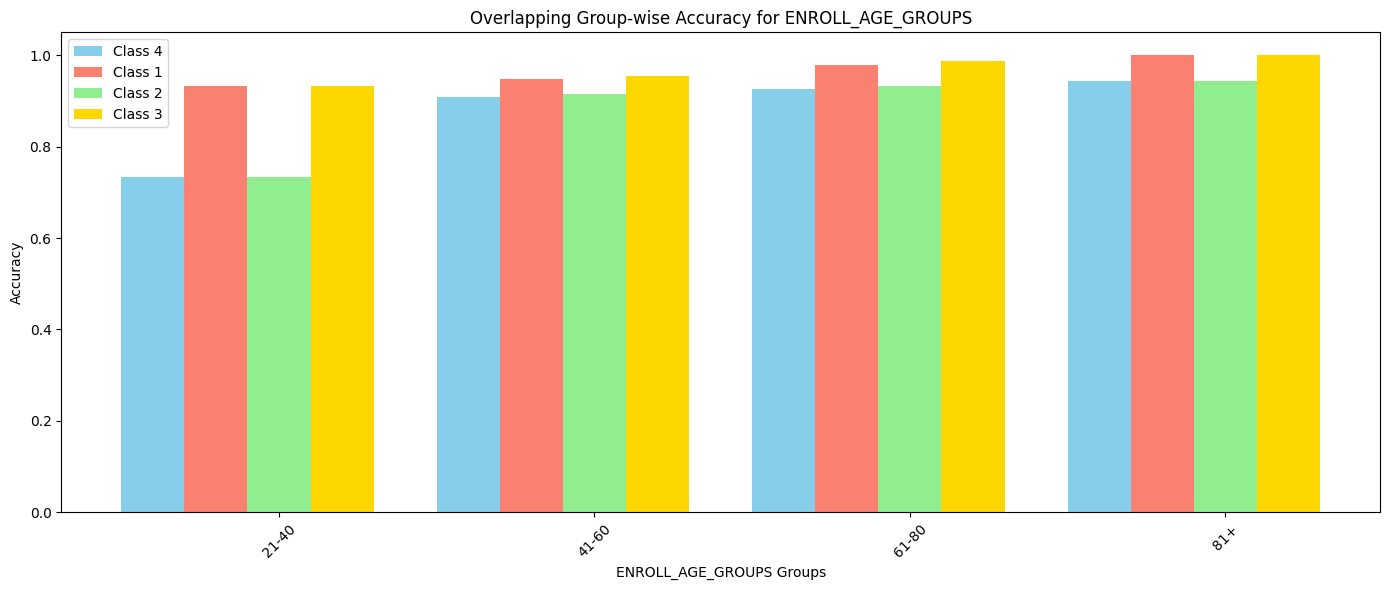

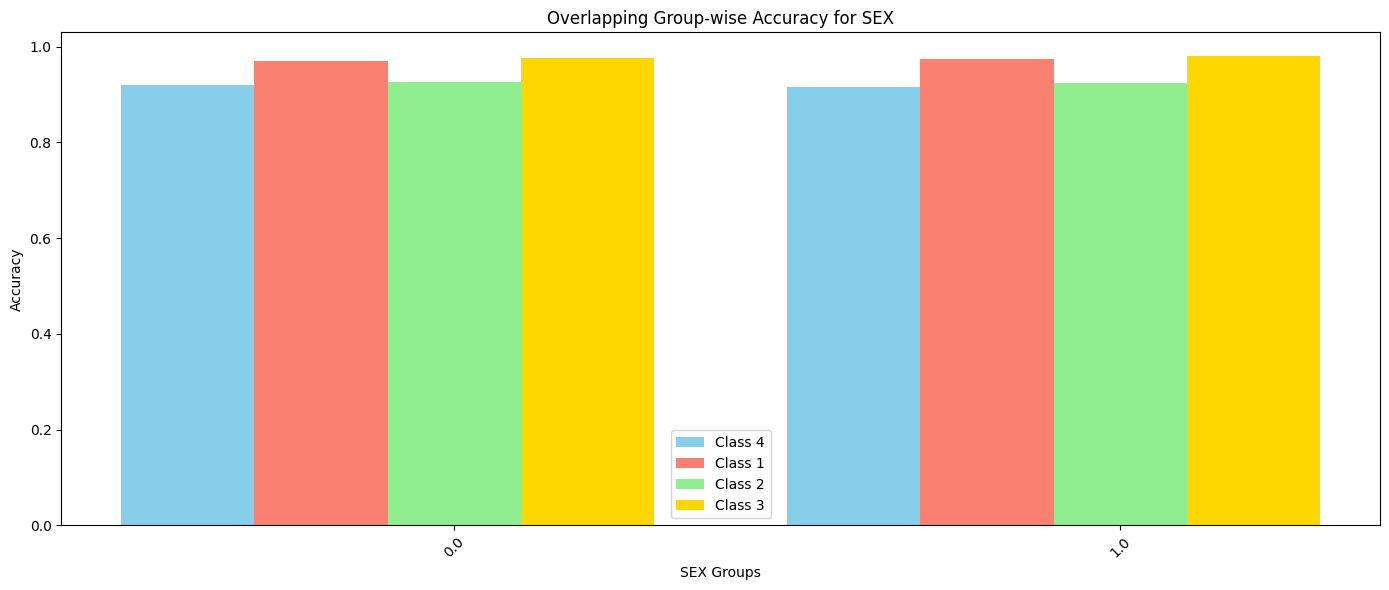

In [6]:
# Multiclass Fairness Evaluation using One-vs-Rest
fairness_report = {}

for class_label in y_test.unique():
    print(f"\nFairness Evaluation for Class {class_label}:")

    # Convert to binary labels for One-vs-Rest
    y_test_binary = (y_test == class_label).astype(int)
    y_pred_binary = (y_pred == class_label).astype(int)

    for feature in ["ENROLL_AGE_GROUPS", "SEX"]:
        print(f"\n  Sensitive Feature: {feature}")

        # Calculate fairness metrics
        dp_diff = demographic_parity_difference(y_test_binary, y_pred_binary, sensitive_features=sensitive_features_test[feature])
        eo_diff = equalized_odds_difference(y_test_binary, y_pred_binary, sensitive_features=sensitive_features_test[feature])

        print(f"    Demographic Parity Difference: {dp_diff}")
        print(f"    Equalized Odds Difference: {eo_diff}")

        # Group-wise accuracy
        metric_frame = MetricFrame(metrics=accuracy_score,
                                   y_true=y_test_binary,
                                   y_pred=y_pred_binary,
                                   sensitive_features=sensitive_features_test[feature])

        print(f"    Accuracy by Group for {feature}:\n{metric_frame.by_group}")

        # Save metrics for the report
        fairness_report[(class_label, feature)] = {
            "Demographic Parity Difference": dp_diff,
            "Equalized Odds Difference": eo_diff,
            "Accuracy by Group": metric_frame.by_group.to_dict()
        }

        # Generate concatenated graphs for each sensitive feature
for feature in ["ENROLL_AGE_GROUPS", "SEX"]:
    plot_concatenated_accuracy(fairness_report, feature, y_test.unique())